# Training a model in the tensorflow model zoo

First, make sure to run this notebook in the environment created for this purpose, called *RiSE-mvasqu49*. Pick a model from the repository [Tensorflow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), and clone or download it. The following steps are performed following [this](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10) tutorial.

#### Download TensorFlow Object Detection API repository from GitHub
Clone the models repository.

In [1]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


Go to a previous commit for the reppository, in order to perform correctly the training.

In [2]:
%cd models
!git reset --hard 079d67d9a0b3407e8d074a200780f3835413ef99

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/models
HEAD is now at 079d67d9 Merge pull request #3296 from unratito/patch-1


#### Compile Protobufs and run setup.py
To use the object detection API from tensorflow.


In [3]:
%cd research/
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py build
!python setup.py install
%cd ..

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/models/research
running build
running build_py
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/grid_anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/hyperparams_pb2.py -> build/lib/object_detection/

#### Configure PYTHONPATH environment variable
A PYTHONPATH variable must be created that points to the \models, \models\research, and \models\research\slim directories. 

In [4]:
import sys
import os

PATH = os.getcwd() + "/research/:" + os.getcwd() + "/research/object_detection/:" + os.getcwd() + "/research/slim/"
os.environ["PYTHONPATH"] = PATH

### Generate the training dataset

#### Gather and label images
For the image labeling, we used the [LabelImg](https://github.com/tzutalin/labelImg) tool. LabelImg saves a .xml file containing the label data for each image. These .xml files will be used to generate TFRecords, which are one of the inputs to the TensorFlow trainer.

#### Generate csv file
Select the train and test data, and put them in the images folder In the repository for the tutorial, there are two scripts called 'xml_to_csv.py', that takes the xml provided by the labeling and creates a csv containing the information for the tf.record to be created.

In [5]:
%cd ..

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook


In [6]:
%cd train

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/train


#### Run the xml_to_csv.py file
This script translates the information contained in the xml files and generates a csv in order to create a tf.record, necessary to feed the model with our data. In order to use this script, we must have an xml file for each one of the images in the same folder. Next, generate the csv.

In [7]:
!python xml_to_csv.py

Successfully converted xml to csv.
Successfully converted xml to csv.


#### Generate tf.record
Now, with the script 'generate_tfrecord.py' we are going to generate the tf.record In order to use this script with other dataset, it is necessary to provide the label map, starting in line 31, with the new label map, where each object is assigned an ID number. Next, generate the tf.record.

In [8]:
!python generate_tfrecord.py --csv_input='images/train_labels.csv' --image_dir='images/train' --output_path='train.record'
!python generate_tfrecord.py --csv_input='images/test_labels.csv' --image_dir='images/test' --output_path='test.record'

Successfully created the TFRecords: /media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/train/train.record
Successfully created the TFRecords: /media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/train/test.record


### Download
The model that will be used is the SSD Mobilenet. Download the model from the model zoo mentioned above. The model must be located in the training folder.

In [9]:
%cd training/

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/train/training


In [10]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar xvf ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!rm ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2019-06-11 10:09:10--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.30.208, 2800:3f0:4005:400::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.30.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  73,00M  22,7MB/s    in 3,5s    

2019-06-11 10:09:14 (21,1 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’ saved [76541073/76541073]

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1

### Configure training 

#### Label map
The label map tells the trainer what each object is by defining a mapping of class names to class ID numbers. Yo can modify the 'labelmap.pbtxt' file in the training folder to perform this step. The label map ID numbers should be the same as what is defined in the generate_tfrecord.py file.

#### Configure training
Finally, the object detection training pipeline must be configured. It defines which model and what parameters will be used for training.

Navigate to models\research\object_detection\samples\configs and copy the '...pets.config' file for the model chosen into the \object_detection\training directory.

Make the following changes to the '...config file'. Note: The paths must be entered with single forward slashes (NOT backslashes), or TensorFlow will give a file path error when trying to train the model! Also, the paths must be in double quotation marks ( " ), not single quotation marks ( ' ). You can see the example used in the training folder.

* Change num_classes to the number of different objects you want the classifier to detect. 

* Change fine_tune_checkpoint to the path to the model.ckpt downloaded from the model.

* Change the input_path for the path to te train.record generated.

* Change the label_map_path for the path to the modified label map.

* Change the num_examples to the umber of images you have in the \images\test directory.

Save the file after the changes have been made.

In [11]:
%cd ../../models

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/models


Ready to go, run the following line and make sure everything is in the right path. After a while, you will see that the loss does not change a lot, so you can stop the training and continue.

In [12]:
!python research/object_detection/train.py --logtostderr --train_dir=../train/training/ --pipeline_config_path=../train/training/ssd_mobilenet_v1_coco.config

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
2019-06-11 10:18:41.741402: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-11 10:18:41.742530: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op se

#### Export the trained model
In order to use the new model, we will export the inference graph constructed in the thaining. Make sure the paths are correct.

In [13]:
%cd research/object_detection/

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/models/research/object_detection


In [15]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path ../../../train/training/ssd_mobilenet_v1_coco.config --output_directory ../../../train/inference_graph/ --trained_checkpoint_prefix $(python -c "import os; print('../../../train/training/' + max(['.'.join(i.split('.')[:2]) for i in os.listdir('../../../train/training') if 'model.ckpt-' in i]))")

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
2019-06-11 10:25:00.047190: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-11 10:25:00.048176: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
%cd ../..

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/models


## Using the trained model

Necessary imports

In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
import pandas as pd
import datetime
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt

import os
PATH = os.getcwd() + "research/:" + os.getcwd() + "research/object_detection/:" + os.getcwd() + "research/slim/"
os.environ["PYTHONPATH"] = PATH
sys.path.append(os.getcwd() + "/research/") # NEW
sys.path.append(os.getcwd() + "/research/object_detection")
from research.object_detection.utils import label_map_util
from research.object_detection.utils import visualization_utils as vis_util

In [21]:
%cd ../train

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/train


In [23]:
# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 8

In [24]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

#### Now, we will run the inference with a big set of images.

In [25]:
%cd ../val

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val


In [26]:
images = []
for x in os.listdir('validation'):
    if x[-3:] == 'jpg':
        images.append(x)
print(len(images))

195


In [27]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [28]:
def inference(img):
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('model.ckpt.meta')
        new_saver.restore(sess, 'model.ckpt')

        # Input tensor is the image
        image_tensor = tf.get_default_graph().get_tensor_by_name("image_tensor:0")

        # Output tensors are the detection boxes, scores, and classes
        # Each box represents a part of the image where a particular object was detected
        detection_boxes = tf.get_default_graph().get_tensor_by_name('detection_boxes:0')

        # Each score represents level of confidence for each of the objects.
        # The score is shown on the result image, together with the class label.
        detection_scores = tf.get_default_graph().get_tensor_by_name('detection_scores:0')
        detection_classes = tf.get_default_graph().get_tensor_by_name('detection_classes:0')

        # Number of objects detected
        num_detections = tf.get_default_graph().get_tensor_by_name('num_detections:0')

        image = cv2.imread(img)
        image = cv2.resize(image,(100, 68)) 
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_expanded = np.expand_dims(image, axis=0)
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_expanded})

In [29]:
# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
from collections import Counter
import random
from tqdm import tqdm

th = 0.5

bb = {}
cc = [[] for _ in range(8)]
dd = []
categories = ['car', 'bus', 'camper', 'industrial', 'motorcycle', 'taxi', 'truck', 'van']

for img in tqdm(images):
    #print()
    #date = datetime.datetime.strptime('-'.join(img.split('-')[1:])[:-4], '%m-%d-%H:%M')
    date = img[:-4]#date.replace(year=2018)
    dd.append(date)
    image = cv2.imread('validation/'+img)
    image_expanded = np.expand_dims(image, axis=0)
    h, w, _ = image.shape
    scale = np.array([h, w, h, w]).reshape(1, 1, 4) # NEW
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})
    bb[img[:-4]] = (boxes[:,scores[0] > th,:] * scale, 
                    scores[0][scores[0] > th],
                    classes[0][scores[0] > th].astype(np.int)) # NEW
    counts = Counter(classes[0][scores[0] > th].astype(np.int))
    for i in range(8):
        cc[i].append(counts[i+1])
    
cs = pd.DataFrame(np.matrix(cc).transpose(), index=dd)
cs.columns = categories
cs.to_csv('counter.csv')

100%|██████████| 195/195 [00:15<00:00, 12.98it/s]


Finally, this is the counting results from the objects in the images, in a csv.

In [30]:
cs.head()

,car,bus,camper,industrial,motorcycle,taxi,truck,van
10-02-25-09:02,9,13,17,15,10,7,21,8
10-02-25-09:03,6,14,15,18,14,9,18,6
10-02-25-09:04,10,18,15,14,10,10,17,6
10-02-25-09:06,8,15,15,15,11,10,19,7
10-02-25-09:07,10,11,14,17,12,11,20,5


In [31]:
xml =[]
for x in os.listdir('validation'):
    if x[-3:] == 'xml':
        xml.append(x)

In [32]:
import xml.etree.ElementTree as ET
import os
import datetime

y_true = cs.copy() * 0

for files in xml:
    tree = ET.parse('validation/' + files)
    root = tree.getroot()
    for mem in root.findall('object'):
        date, typ = files, mem[0].text
        if typ == 'ar':
            typ = 'car'
        try:
            y_true[typ][date[:-4]] += 1
        except:
            continue

In [33]:
(y_true == cs).mean()

car           0.005128
bus           0.000000
camper        0.000000
industrial    0.000000
motorcycle    0.000000
taxi          0.000000
truck         0.000000
van           0.000000
dtype: float64

In [34]:
(y_true.sum(axis=1) == cs.sum(axis=1)).mean() * 100

0.0

In [35]:
(y_true.sum(axis=1) > cs.sum(axis=1)).mean() * 100

0.0

In [36]:
(y_true == cs).mean()

car           0.005128
bus           0.000000
camper        0.000000
industrial    0.000000
motorcycle    0.000000
taxi          0.000000
truck         0.000000
van           0.000000
dtype: float64

In [37]:
cs.sum()

car           1840
bus           2457
camper        2954
industrial    2769
motorcycle    2730
taxi          2454
truck         3412
van            884
dtype: int64

In [39]:
y_true.sum()

car           481
bus            74
camper        167
industrial      4
motorcycle    341
taxi          190
truck         173
van            29
dtype: int64

In [40]:
(y_true.sum() - cs.sum())/y_true.sum() * 100

car            -282.536383
bus           -3220.270270
camper        -1668.862275
industrial   -69125.000000
motorcycle     -700.586510
taxi          -1191.578947
truck         -1872.254335
van           -2948.275862
dtype: float64

# Validación

In [41]:
%mkdir detections
%cd detections

mkdir: cannot create directory ‘detections’: File exists
/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val/detections


In [47]:
k = '10-02-25-09:09'
v = bb[k]
for k, v in bb.items():
    #<class_name> <confidence> <left> <top> <right> <bottom>
    tmp = pd.DataFrame()

    box, confidence, class_name = v
    box.astype(np.int)
    ymin = box[0,:,0]
    xmin = box[0,:,1]
    ymax = box[0,:,2]
    xmax = box[0,:,3]
    
    tmp['class_name'] = np.array(categories)[class_name - 1]
    tmp['confidence'] = confidence
    tmp['left'] = xmin
    tmp['top'] = ymax
    tmp['right'] = xmax
    tmp['bottom'] = ymin
    
    tmp.to_csv(path_or_buf=k + '.txt', header=False, index=False, sep=' ')

In [52]:
%cd ..
!python xml_to_csv.py

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val
Successfully converted xml to csv.


In [53]:
val = pd.read_csv('validation_labels.csv',index_col =0)

In [54]:
%mkdir groundtruths/
%cd groundtruths/

mkdir: cannot create directory ‘groundtruths/’: File exists
/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val/groundtruths


In [65]:
import csv 
for k in bb.keys():
    # <class_name> <left> <top> <right> <bottom>
    try:
        tmp = val.loc[k][['class', 'xmin', 'ymax', 'xmax', 'ymin']]
        try:
            tmp.to_csv(path_or_buf=k + '.txt', header=False, index=False, sep=' ')
        except:
            tmp.to_frame().transpose().to_csv(path_or_buf=k + '.txt', header=False, index=False, line_terminator=' ')        
    except:
        print(k)

In [57]:
%cd ..
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val
Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 411 (delta 7), reused 3 (delta 0), pack-reused 396
Receiving objects: 100% (411/411), 2.65 MiB | 2.84 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [68]:
%cd Object-Detection-Metrics
!python pascalvoc.py -gt ../groundtruths/ -det ../detections/

[Errno 2] No such file or directory: 'Object-Detection-Metrics'
/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val/Object-Detection-Metrics
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
AP: 0.00% (ar)
AP: 0.05% (bus)
AP: 0.08% (camper)
AP: 0.28% (car)
AP: 0.00% (industrial)
AP: 0.17% (motorcycle)
AP: 0.03% (taxi)
AP: 0.15% (truck)
AP: 0.11% (van)
mAP: 0.10%


In [69]:
cd results/

/media/camivasz/D6E67D60E67D4233/Nowcasting/Notebook/val/Object-Detection-Metrics/results


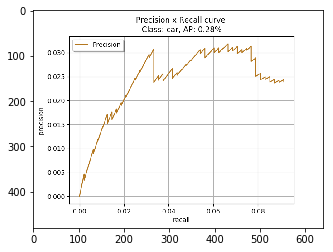

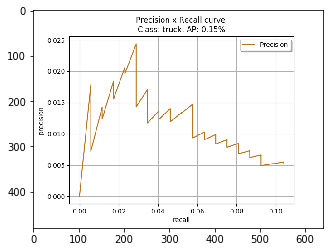

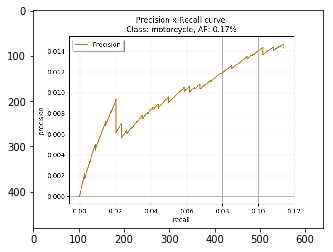

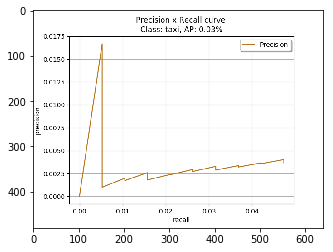

In [70]:
a = cv2.imread('car.png')
b = cv2.imread('truck.png')
c = cv2.imread('motorcycle.png')
d = cv2.imread('taxi.png')
plt.imshow(a)
plt.show()
plt.imshow(b)
plt.show()
plt.imshow(c)
plt.show()
plt.imshow(d)
plt.show()